In [2]:
import matplotlib.pyplot as plt 
import numpy as np

from time import time
from PIL import Image

import torch
import torchvision.transforms as transforms

from hemul.cipher import *
from hemul.scheme import *

device = "cpu"

In [3]:
from load_test_model import get_test_model

org_model = get_test_model()
# specify the image classes
org_model

ConvNeuralNet(
  (conv_layer1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_layer4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [4]:
fn_param = "SimpleCNN_ReLU_minimax_v2.pt"

trained_param = torch.load(fn_param, map_location=torch.device(device))
trained_param = {k: v.cpu() for k, v in trained_param.items()} # to cpu()
org_model.load_state_dict(trained_param)
org_model.eval() ## If not eval(), running_mean and running_var of batch_norm changes

# To numpy
params_np = {k: v.numpy() for k, v in trained_param.items()}

torch.Size([1, 3, 32, 32])


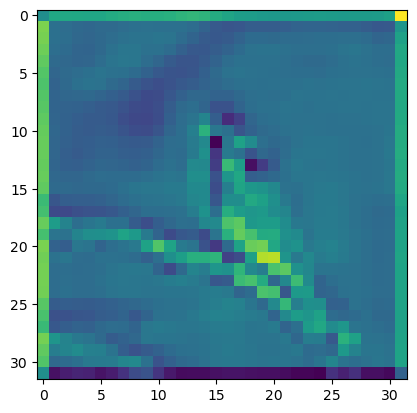

In [6]:
img = np.array(Image.open("./bird6.png"))
to_tensor = transforms.ToTensor() # [n_channel, nh, nw]
img_tensor = to_tensor(img).unsqueeze(0) # [n_batch, n_channel, nh, nw]
n_batch, n_channel, nh, nw = img_tensor.shape

print(img_tensor.shape)

org_tt0 = org_model.conv_layer1(img_tensor)

x2 = org_tt0[0,0,...].detach().numpy()

plt.imshow(x2)

## GAZELLE

In [8]:
from math import floor, ceil, sqrt

In [9]:
img_tensor.shape

torch.Size([1, 3, 32, 32])

In [62]:
img2d = np.array(img_tensor[0,0,:,:])

wi, hi = img2d.shape

In [63]:
# kernel
kernel = org_model.conv_layer1.weight.detach().numpy()

k2d = kernel[0,0,:,:]
fw, fh = k2d.shape

print(k2d)

[[-0.03024577  0.07654995  0.05950021]
 [ 0.00516844 -0.03511824 -0.11581486]
 [-0.06510032 -0.08480114 -0.10425694]]


### FHE context

### 1. padded SISO 스킵

In [44]:
if False:
    nslots = 2**14

    pad = int((fw -1) / 2)
    padded = np.zeros((wi+fw-1, hi+fh-1))

    padded[pad:-pad, pad:-pad] = ch1_2d

    raster_scan = padded.ravel()

    ctxt = np.zeros(nslots)
    ctxt[:len(raster_scan)] = raster_scan

### 2. Packed SISO
- nslots = wi * hi

In [47]:
nslots = wi*hi

raster_scan = ch1_2d.ravel()

In [50]:
# convolve

## rotate input
# fw * fh -1 rotations
rotated = []
ctd = np.zeros(nslots)

for i1 in range(fh):
    cti1=[]
    for i2 in range(fw):
        roll = -wi*int(i1-(fh-1)/2) + int(i2-(fw-1)/2)
        if roll != 0:
            cti1.append(np.roll(raster_scan, roll)) 
        else:
            cti1.append(raster_scan)
    rotated.append(cti1)

In [7]:
def MultWgt_bck(hi,wi, ifh, ifw, kernel):
    Uout = np.ones((hi, wi))
    range_h = np.arange(hi)
    range_w = np.arange(wi)
    fh, fw = kernel.shape
    pad_h = int((fh-1)/2) # height 방향 padding
    pad_w = int((fw-1)/2) # width 방향 padding
    for ihi in range(hi): # hi
        for iwi in range(wi): # wi
            #for i5 in range(n5): # ti
            if  not ((ihi - pad_h + ifh) in range_h) or \
                not ((iwi - pad_w + ifw) in range_w):
                Uout[ihi,iwi] = 0
            else:
                pass
                #Uout[ihi,iwi] = 1
    return Uout


def weight_mask(hi,wi, ifh, ifw, fh, fw):
    Uout = np.ones((hi, wi))
    pad_h = int((fh-1)/2) # height 방향 padding
    pad_w = int((fw-1)/2) # width 방향 padding

    if ifh < pad_h:
        Uout[:pad_h,:] = 0 # 위로 넘음
    elif ifh >= (fh - pad_h): # 2 >= 3 - 1
        Uout[-(pad_h):,:] = 0 # 아래로 넘음
    
    if ifw < pad_w:
        Uout[:,:pad_w] = 0 # 좌로 넘음
    elif ifw >= (fw - pad_w): # 
        Uout[:,-(pad_w):] = 0 # 우로 넘음
    
    return Uout

In [ ]:
[111111111111111111111111111111111111111111111,222222222222222222222222222222222222222222222222222222,44444444444444444444444]

In [ ]:
[1,2,3,4,1,2,3,4,1,2,3,4]

In [ ]:
multi_channel_kernel = np.zeros(nslots)
npix = wi*hi
for i3 in range(cn):
    k2d = k3d[i1,i2,i3]
    multi_channel_kernel[i3*npix:(i3+1)*npix] = k2d[i1,i2]


ifh, ifw 0 0

ifh, ifw 0 1

ifh, ifw 0 2

ifh, ifw 1 0

ifh, ifw 1 1

ifh, ifw 1 2

ifh, ifw 2 0

ifh, ifw 2 1

ifh, ifw 2 2


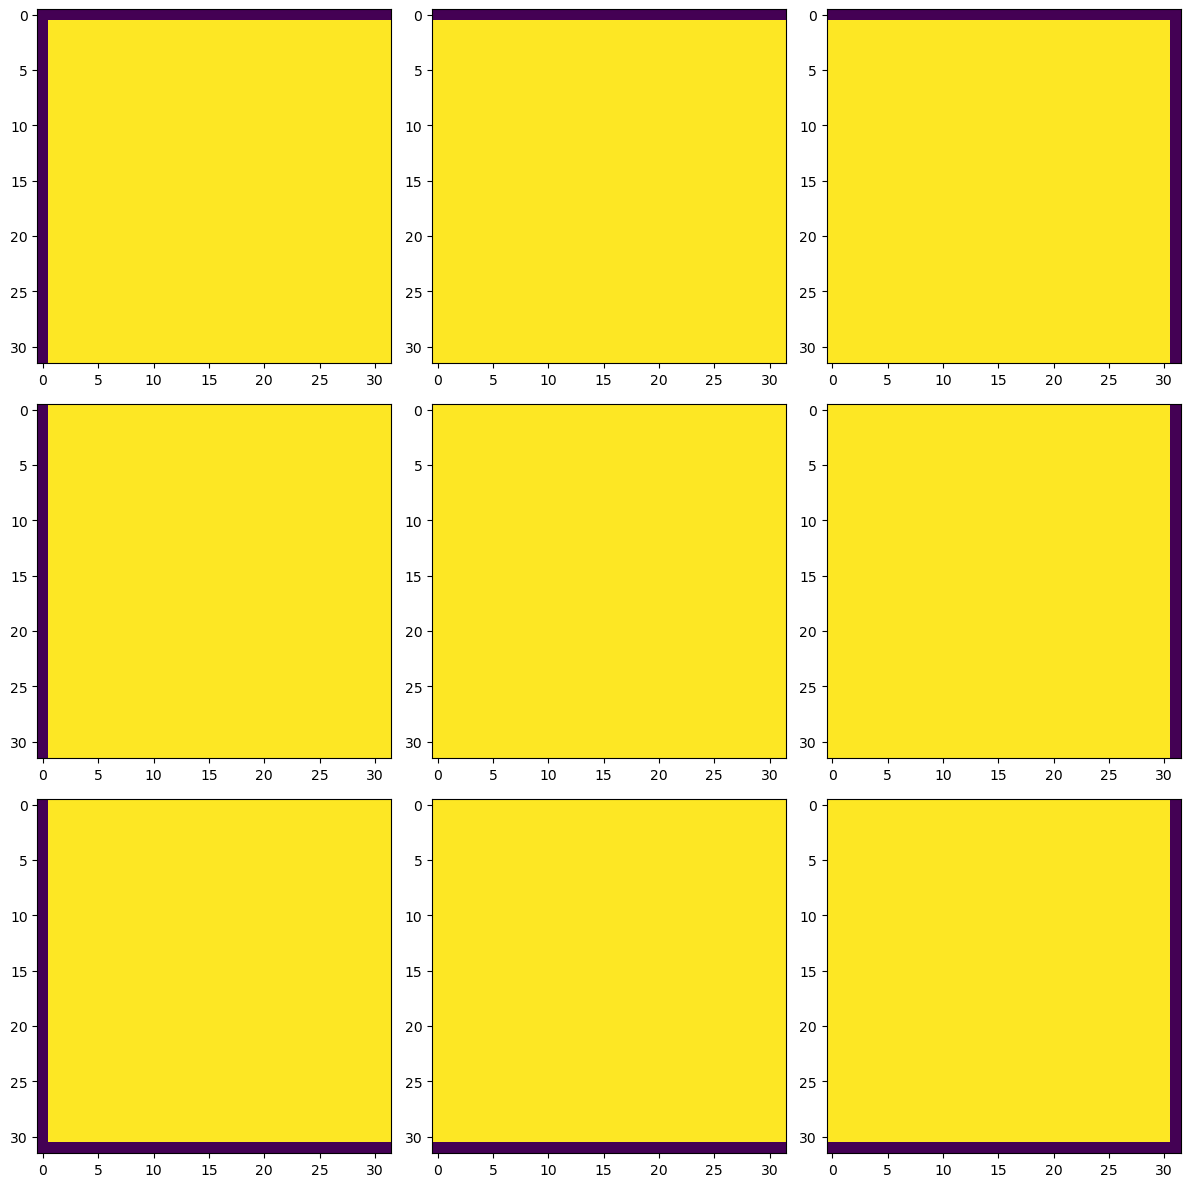

In [124]:
fig, axs = plt.subplots(3,3, figsize=(12,12))

ctb = np.zeros(nslots)
pad_h = int((fh-1)/2) # height 방향 padding
pad_w = int((fw-1)/2) # width 방향 padding
for i1 in range(fh):
    for i2 in range(fw):
        Uout = weight_mask(hi, wi, i1, i2, fh, fw)
        axs[i1,i2].imshow(Uout, vmax=1, vmin=0)
        
        multwgt = np.zeros(nslots)
        multwgt[:hi*wi] = Uout.ravel() * k2d[i1,i2]
        
        #get_Up(Uout, Uin, i1, i2, i, ki, fh, fw, hi, wi, ci)
        #multwgt = VEC(Uout, nslots)
        #len_multwgt = len(multwgt)
        ctb += rotated[i1][i2] * multwgt # multc

plt.tight_layout()

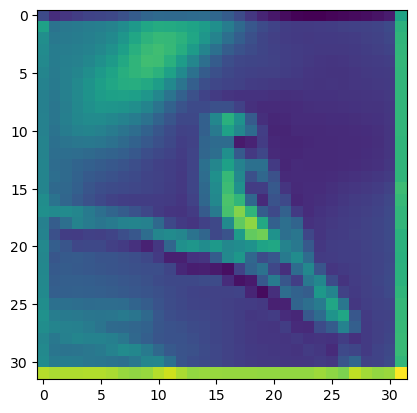

In [126]:
plt.imshow(ctb[:hi*wi].reshape(hi,wi))
plt.show()

rot: 9 - 1; 
multc: 9

## Channel packing